In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, calinski_harabasz_score
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.mixture import GaussianMixture


In [2]:
df2 = pd.read_csv("/workspaces/final-project-karina-munoz/data/processed/clean_sn_data.csv")
df2.info()
df2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701 entries, 0 to 1700
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CID                1701 non-null   object 
 1   RA                 1701 non-null   float64
 2   DEC                1701 non-null   float64
 3   zHD                1701 non-null   float64
 4   zCMB               1701 non-null   float64
 5   MU_SH0ES           1701 non-null   float64
 6   MU_SH0ES_ERR_DIAG  1701 non-null   float64
 7   d_L_Mpc            1701 non-null   float64
 8   velocity_kms       1701 non-null   float64
dtypes: float64(8), object(1)
memory usage: 119.7+ KB


,RA,DEC,zHD,zCMB,MU_SH0ES,MU_SH0ES_ERR_DIAG,d_L_Mpc,velocity_kms
count,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000
mean,157.247004,6.978712,0.221229,0.221090,38.336629,0.242601,1168.643290,52045.674742
std,117.146180,26.985496,0.249271,0.249337,3.374499,0.098390,1539.673802,48125.345691
min,0.895900,-80.177600,0.001220,0.001220,28.998700,0.114803,6.305797,365.523135
25%,40.916900,-4.967300,0.027730,0.027210,35.289200,0.180815,114.245736,8198.012300
50%,150.305000,0.429400,0.163750,0.163570,39.329300,0.218994,734.277127,45117.396662
75%,243.224000,23.352800,0.328680,0.328590,41.077800,0.279961,1642.706592,82974.884729
max,359.884000,84.678300,2.261370,2.261300,46.182800,1.517470,17240.902664,248266.005599


In [3]:
df2['velocity_kms'].describe()              #checking for off values such as negative distance or velocity
df2['d_L_Mpc'].describe()
df2['zHD'].describe()

count    1701.000000
mean        0.221229
std         0.249271
min         0.001220
25%         0.027730
50%         0.163750
75%         0.328680
max         2.261370
Name: zHD, dtype: float64

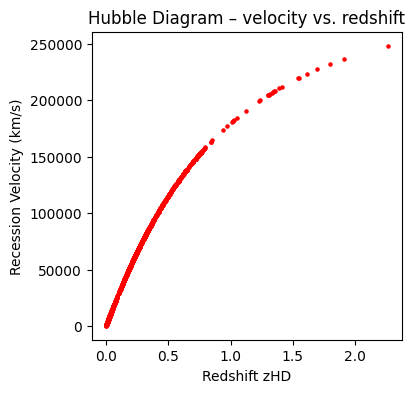

In [4]:
luminosity_distance = df2['d_L_Mpc']
velocity = df2["velocity_kms"]

plt.figure(figsize=(4,4))
plt.scatter(df2["zHD"], df2["velocity_kms"], s=5, c = "red")
plt.xlabel("Redshift zHD")
plt.ylabel("Recession Velocity (km/s)")
plt.title("Hubble Diagram – velocity vs. redshift")
plt.show()

#proof that a linear regression line is possible at low z, howevernotthe. whole data set. 

741
64.63371646290183
539.3106730436666


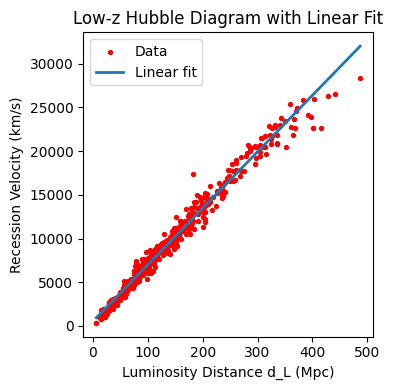

In [5]:
#filtering low-z subset
df_low_z = df2[df2['zHD'] < 0.1]

print(len(df_low_z))            #checking to make sure there are enough data points remaining for regression

x = df_low_z["d_L_Mpc"].values.reshape(-1, 1)
y = df_low_z["velocity_kms"].values

model = LinearRegression()      #blank regression model that hasn't been trained
model.fit(x, y) 

H0_estimate = model.coef_[0]
intercept = model.intercept_

print(H0_estimate)
print(intercept)

x_line = np.linspace(x.min(), x.max(), 200).reshape(-1,1)
y_line = model.predict(x_line)
plt.figure(figsize=(4, 4))
plt.scatter(df_low_z["d_L_Mpc"], df_low_z["velocity_kms"], s=8, label="Data", c="red")
plt.plot(x_line, y_line, linewidth=2, label="Linear fit", )

plt.xlabel("Luminosity Distance d_L (Mpc)")
plt.ylabel("Recession Velocity (km/s)")
plt.title("Low-z Hubble Diagram with Linear Fit")
plt.legend()
plt.tight_layout()
plt.show()

In the local universe (z < 0.1), the expansion is well-approximated by a linear relationship between recession velocity and distance
Most of the scatter comes from:
* peculiar velocities (galaxies moving within clusters)
* measurement uncertainties in SN magnitudes
* calibration noise

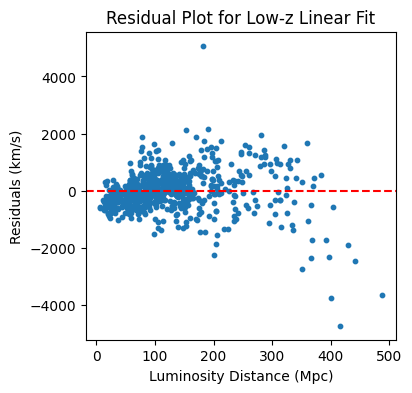

In [6]:
# Compute predictions
y_pred = model.predict(x)

# Residuals
residuals = y - y_pred

plt.figure(figsize=(4,4))
plt.scatter(df_low_z["d_L_Mpc"], residuals, s=10)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Luminosity Distance (Mpc)")
plt.ylabel("Residuals (km/s)")
plt.title("Residual Plot for Low-z Linear Fit")
plt.show()


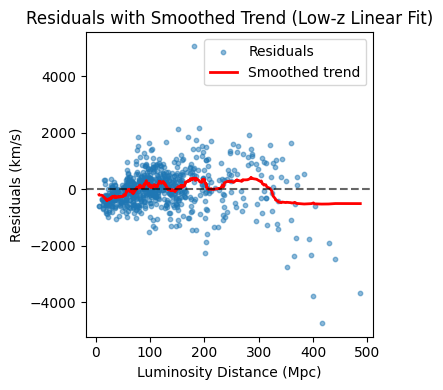

In [7]:
import numpy as np
import matplotlib.pyplot as plt

sorted_idx = np.argsort(df_low_z["d_L_Mpc"].values)
x_sorted = df_low_z["d_L_Mpc"].values[sorted_idx]
res_sorted = residuals[sorted_idx]

window = 50  
kernel = np.ones(window) / window
smooth = np.convolve(res_sorted, kernel, mode='same')


plt.figure(figsize=(4,4))
plt.scatter(df_low_z["d_L_Mpc"], residuals, s=10, alpha=0.5, label="Residuals")
plt.plot(x_sorted, smooth, color='red', linewidth=2, label="Smoothed trend")
plt.axhline(0, color='black', linestyle='--', alpha=0.6)
plt.xlabel("Luminosity Distance (Mpc)")
plt.ylabel("Residuals (km/s)")
plt.title("Residuals with Smoothed Trend (Low-z Linear Fit)")
plt.legend()
plt.tight_layout()
plt.show()



The smoothing of residuals, depicted after performing LOWESS-style smoothing, shows a negative curvature at higher Luminosity Distances, which underestimates the nonlinearity even when z < 0.1. At small luminosity distances, residuals scatter symmetrically around zero, but at larger distances, the LOWESS curve bends downward.

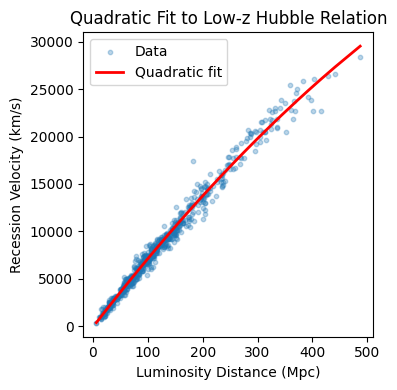

In [ ]:
df_low_z = df2[df2["zHD"] < 0.1].copy()

df_low_z["d_L_Mpc_sq"] = df_low_z["d_L_Mpc"]**2

x_quad = df_low_z[["d_L_Mpc", "d_L_Mpc_sq"]].values
y_quad = df_low_z["velocity_kms"].values

quad_model = LinearRegression()
quad_model.fit(x_quad, y_quad)

coef_linear = quad_model.coef_[0]      # coefficient on distance
coef_quad   = quad_model.coef_[1]      # coefficient on distance^2
intercept   = quad_model.intercept_

dist_sort = np.sort(df_low_z["d_L_Mpc"].values)

quad_curve = (intercept + coef_linear*dist_sort + coef_quad*dist_sort**2)

plt.figure(figsize=(4,4))
plt.scatter(df_low_z["d_L_Mpc"], df_low_z["velocity_kms"], s=10, alpha=0.3, label="Data")
plt.plot(dist_sort, quad_curve, color='red', linewidth=2, label="Quadratic fit")
plt.xlabel("Luminosity Distance (Mpc)")
plt.ylabel("Recession Velocity (km/s)")
plt.title("Quadratic Fit to Low-z Hubble Relation")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
y_true = df_low_z["velocity_kms"].values
y_pred_linear = model.predict(df_low_z["d_L_Mpc"].values.reshape(-1, 1))

# --- Quadratic model predictions ---
d = df_low_z["d_L_Mpc"].values
y_pred_quad = intercept + coef_linear*d + coef_quad*(d**2)

# --- Metrics ---
def print_metrics(name, y_true, y_pred):
    print(f"\n{name} Model Metrics:")
    print("R²:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))

print_metrics("Linear", y_true, y_pred_linear)
print_metrics("Quadratic", y_true, y_pred_quad)


Linear Model Metrics:
R²: 0.98294583385191
RMSE: 711.3833741980011
MAE: 492.4525817831241

Quadratic Model Metrics:
R²: 0.9857366607196344
RMSE: 650.5775499014312
MAE: 448.0372081395715
